In [14]:
%matplotlib inline

# Survival analysis with lifelines


The [lifelines package](http://lifelines.readthedocs.org/) is a well documented, easy-to-use Python package for survival analysis.

I had never done any survival analysis and the fact that this has great documentation, made me adventure in the field. From the documentation I was able to understand the key concepts of survival analysis and run a few simple analysis on clinical data gathered by our collaborators from a cohort of cancer patients. This obviously does not mean this is a replacement of proper study of the field, but nonetheless I highly recommend reading the whole documentation for begginers on the topic and the usage of the package to anyone working in the field.


### Getting our hands dirty

Although all one needs for survival analysis are two arrays with the time the patient observation took and if death was observed during that time or not, in reality you're more likely to get from clinicians an Excel file with dates of birth, diagnosis, and death along with other relevant information on the clinical cohort.

Let's read some data in and transform those fields into the time we have been observing the patient (from diagnosis to the last checkup):

> Hint: make sure you tell pandas which columns hold dates and the format they are in for correct date parsing.

In these data, although already anonymized, I have added some jitter for the actual values differ from the real ones.

In [64]:
import pandas as pd

clinical = pd.read_csv(
    "clinical_data.csv",
    parse_dates=["patient_death_date", "diagnosis_date", "patient_last_checkup_date"],
    dayfirst=True)

# get duration of patient observation
clinical["duration"] = clinical["patient_last_checkup_date"] - clinical["diagnosis_date"]

clinical.head()


,patient_last_checkup_date,diagnosis_date,patient_death_date,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,duration
0,2011-12-05,1977-08-23,2011-12-19,F,A0,1,1,1,False,False,False,True,False,False,False,12522 days
1,2015-01-15,1997-08-06,NaT,M,A0,1,NaN,NaN,True,False,False,False,True,False,False,6371 days
2,2011-11-14,1987-03-11,NaT,F,A0,1,1,1,True,False,False,False,False,False,False,9014 days
3,2008-11-15,1992-04-27,2008-12-7,F,A0,1,2,1,True,False,True,False,False,False,False,6046 days
4,2008-10-09,1994-07-19,2009-12-22,M,A0,2,2,2,True,True,False,False,False,False,False,5196 days


Let's check globaly how our patients are doing:

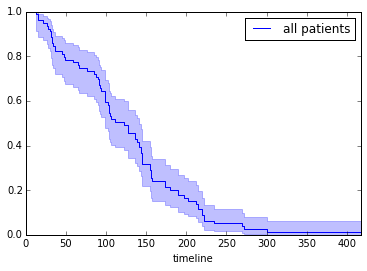

In [60]:
from lifelines import KaplanMeierFitter

# Duration of patient following in months
T = [i.days / 30. for i in clinical["duration"]]
# Observation of death in boolean
# True for observed event (death);
# else False (this includes death not observed; death by other causes)
C = [True if i is not pd.NaT else False for i in clinical["patient_death_date"]]

fitter = KaplanMeierFitter()
fitter.fit(T, event_observed=C, label="all patients")
fitter.plot(show_censors=True)


Now we want to split our cohort according to values in several variables (*e.g.* gender, age, presence/absence of a clinical marker), and check what's the progression of survival, and if differences between groups are significant.

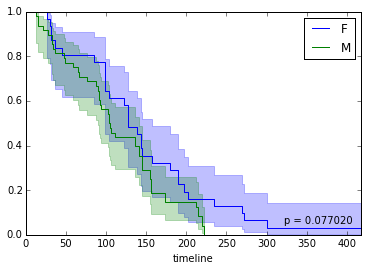

In [61]:
import matplotlib.pyplot as plt
from lifelines.statistics import logrank_test
from matplotlib.offsetbox import AnchoredText

trait = "t1"  # we pick one trait, gender in this case

label = clinical[trait].unique()
label = label[~np.array(map(pd.isnull, label))]

fig, ax = plt.subplots(1)
# Separately for each class
# get index of patients from class
f = clinical[clinical[trait] == "F"].index.tolist()
# fit the KaplarMayer with the subset of data from the respective class
fitter.fit([T[i] for i in f], event_observed=[C[i] for i in f], label="F")
fitter.plot(ax=ax, show_censors=True)

# get index of patients from class
m = clinical[clinical[trait] == "M"].index.tolist()
# fit the KaplarMayer with the subset of data from the respective class
fitter.fit([T[i] for i in m], event_observed=[C[i] for i in m], label="M")
fitter.plot(ax=ax, show_censors=True)

# test difference between curves    
p = logrank_test(
    [T[i] for i in f], [T[i] for i in m],
    event_observed_A=[C[i] for i in f],
    event_observed_B=[C[i] for i in m]).p_value

# add p-value to plot
ax.add_artist(AnchoredText("p = %f" % round(p, 5), loc=4, frameon=False))


We can also see how 

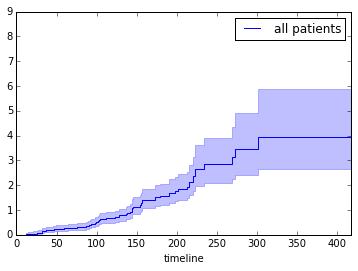

In [62]:
from lifelines import NelsonAalenFitter

fitter = NelsonAalenFitter()
fitter.fit(T, event_observed=C, label="all patients")
fitter.plot(show_censors=True)


Great, so if we make the code more general and wrap it into a function, we can run see how survival or hazard of patients with certain traits differ.

We can also investigate variables with more than one class and compare them in a pairwise fashion.

In [63]:
from lifelines import NelsonAalenFitter
import itertools

def survival_plot(clinical, fitter, fitter_name, feature, time):
    T = [i.days / float(30) for i in clinical[time]]  # duration of patient following
    # events:
    # True for observed event (death);
    # else False (this includes death not observed; death by other causes)
    C = [True if i is not pd.NaT else False for i in clinical["patient_death_date"]]

    fig, ax = plt.subplots(1)

    # All patients together
    fitter.fit(T, event_observed=C, label="all patients")
    fitter.plot(ax=ax, show_censors=True)

    # Filter feature types which are nan
    label = clinical[feature].unique()
    label = label[~np.array(map(pd.isnull, label))]

    # Separately for each class
    for value in label:
        # get patients from class
        s = clinical[clinical[feature] == value].index.tolist()
        fitter.fit([T[i] for i in s], event_observed=[C[i] for i in s], label=str(value))
        fitter.plot(ax=ax, show_censors=True)

    if fitter_name == "survival":
        ax.set_ylim(0, 1.05)

    # Test pairwise differences between all classes
    p_values = list()
    for a, b in itertools.combinations(label, 2):
        a_ = clinical[clinical[feature] == a].index.tolist()
        b_ = clinical[clinical[feature] == b].index.tolist()
        p = logrank_test(
            [T[i] for i in a_], [T[i] for i in b_],
            event_observed_A=[C[i] for i in a_],
            event_observed_B=[C[i] for i in b_]).p_value
        # see result of test with p.print_summary()
        p_values.append("p-value '" + " vs ".join([str(a), str(b)]) + "': %f" % p)

    # Add p-values as anchored text
    ax.add_artist(AnchoredText("\n".join(p_values), loc=8, frameon=False))

    ax.set_title("%s - %s since diagnosis" % (feature, fitter_name))


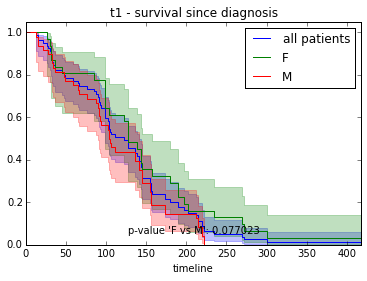

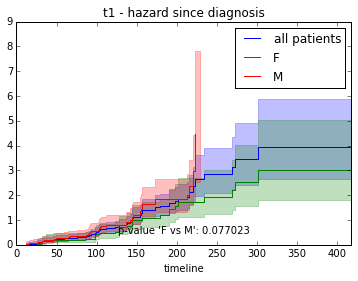

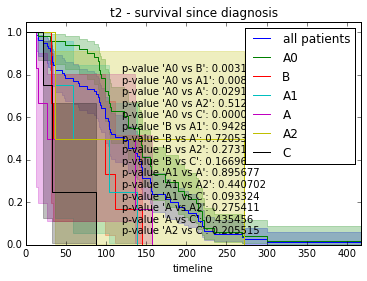

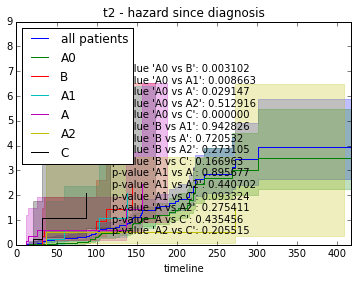

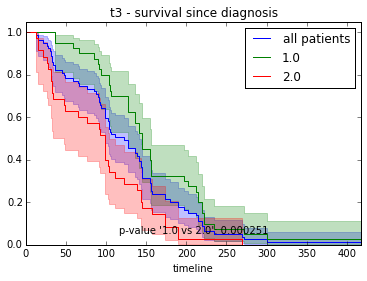

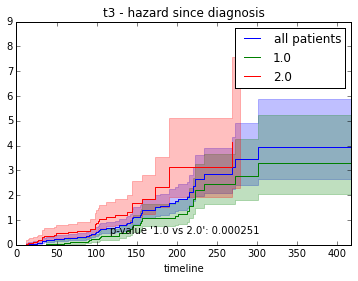

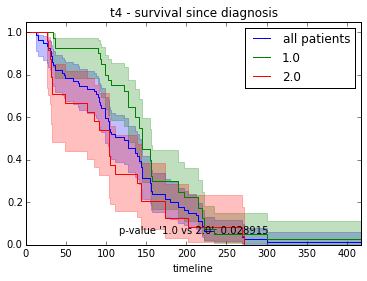

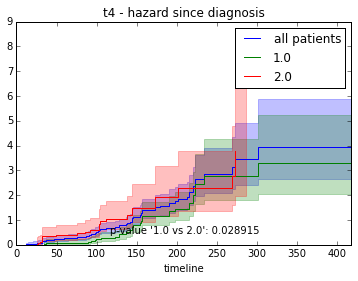

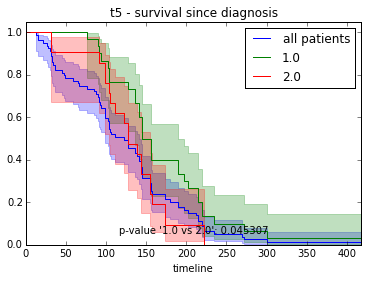

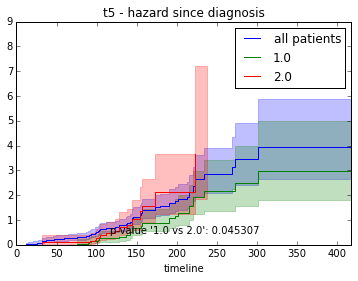

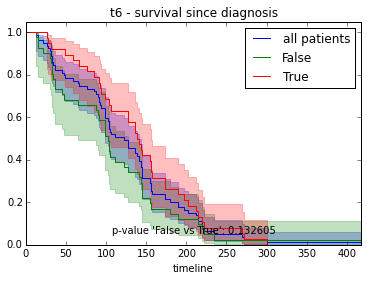

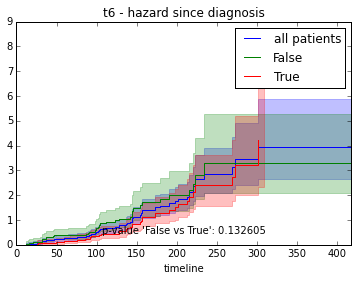

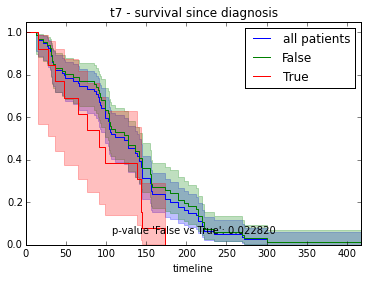

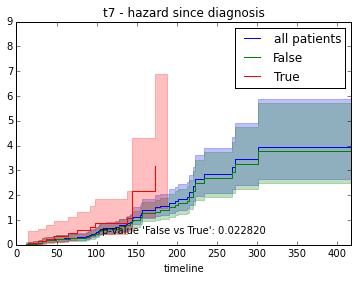

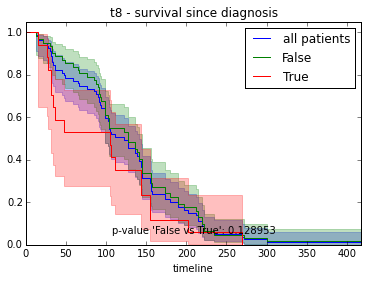

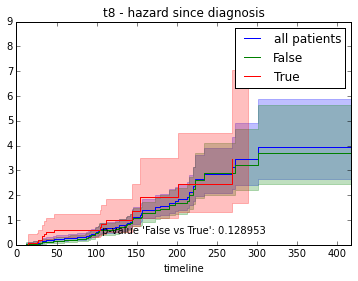

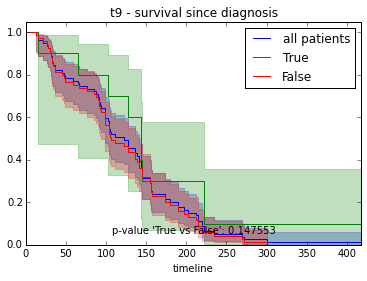

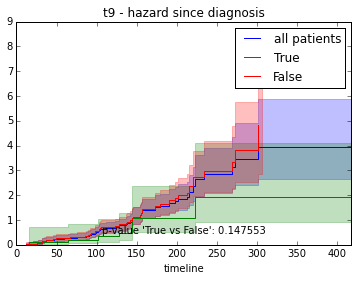

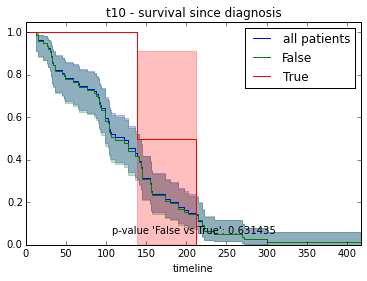

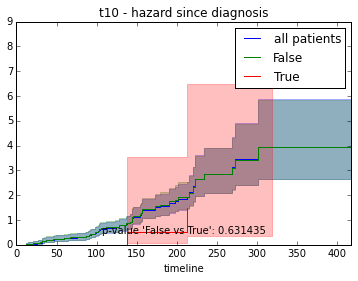

In [58]:

features = ["t%i" % i for i in range(1, 11)]

# For each clinical feature
for feature in features:
    survival_plot(clinical, KaplanMeierFitter(), "survival", feature, "duration")
    survival_plot(clinical, NelsonAalenFitter(), "hazard", feature, "duration")
